In [10]:
"""
For 2 DIMMs results
"""
import pandas as pd
import numpy as np

def get_dual_results(path):
    buffer_dist = []
    statistic = []
    buffers = []
    with open(path, "r") as f:
        for line in f.readlines():
            if (line.startswith("TIME|")):
                statistic.append(line.strip("TIME|").strip("\n").split(","))
            elif (line.startswith("[Number of Buffers]")):
                buffers.append(line.strip("[Number of Buffers]").strip("\n").split(","))
            else:
                buffer_dist.append(line.strip("\n").split(","))
#     if (buffer_dist):
#         buffer_dist = np.array(buffer_dist)
#         buffer_dist = pd.DataFrame(buffer_dist, columns=['cceh0', 'cceh1', 'total'], dtype=np.float)

    if (statistic):
        statistic = np.array(statistic)
        statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
    if (buffers):
        buffers = np.array(buffers)
        buffers = pd.DataFrame(buffers, columns=['CCEH0_buffers', 'CCEH1_buffers'], dtype=np.float)
    
    print(statistic)
    """
    Calculate throughput : (epoch_ops/epoch_time/1024/1024)
    """
    time_epoch = 0.5
    max_size0 = 0
    max_size1 = 0
    for i in range(10):
        th = statistic[statistic["thread"]==i].shape
        if (th[0] > max_size0):
            max_size0 = th[0]

    for i in range(10,20):
        th = statistic[statistic["thread"]==i].shape
        if (th[0] > max_size1):
            max_size1 = th[0]

    print("CCEH0 max runtime = ",max_size0, "CCEH1 max runtime = ", max_size1)
    
    MAX_SIZE = min(max_size0, max_size1)

    cceh0 = np.zeros(max_size0)
    cceh1 = np.zeros(max_size1)
    
    for i in range(10):
        th = statistic[statistic["thread"]==i]
        cur_done = th['cur_done'].values
        last_done = th['last_done'].values
        eopch = cur_done - last_done
        cur_length = cur_done.shape[0]
        padding = np.pad(eopch, (0, max_size0-cur_length), 'constant', constant_values=(0,0))
        cceh0 += padding
    cceh0_Mops = cceh0[:MAX_SIZE]/time_epoch/1024/1024
    time_x = np.array([i for i in np.arange(time_epoch, (MAX_SIZE + 1)*time_epoch, time_epoch)])
    through_x = cceh0_Mops

    for i in range(10, 20):
        th = statistic[statistic["thread"]==i]
        cur_done = th['cur_done'].values
        last_done = th['last_done'].values
        eopch = cur_done - last_done
        cur_length = cur_done.shape[0]

        padding = np.pad(eopch, (0,max_size1-cur_length), 'constant', constant_values=(0,0))
        cceh1 += padding
        
    cceh1_Mops = cceh1[:MAX_SIZE]/time_epoch/1014/1024
    time_y = np.array([i for i in np.arange(time_epoch, (MAX_SIZE + 1)*time_epoch, time_epoch)])
    through_y = cceh1_Mops
    
    print("Overall throughput = ", (sum(through_x) + sum(through_y))/ (MAX_SIZE/2) )
    return time_x, through_x, time_y, through_y, buffers

In [11]:
# time_d0, through_d0, time_d1, through_d1 = get_dual_results("./results_multi/cceh2_dynamic_g1.txt")
# time_d0, through_d0, time_d1, through_d1 = get_dual_results("./results_bufferdist/ccehdual2_g5.txt")
# time_f0, through_f0, time_f1, through_f1 = get_dual_results("./results_multi/cceh2_fixed_g5.txt")

time_d0, through_d0, time_d1, through_d1, dynamic_buffers = get_dual_results("./BufferHashing_Multi/dynamic1.txt")
# time_f0, through_f0, time_f1, through_f1 = get_dual_results("./results_multi/cceh2_fixed_g5.txt")

print (len(time_d0), len(through_d0), len(time_d1), len(through_d1))



     thread   last_done    cur_done  seg_time     time
0      18.0         0.0    690000.0    0.5002   0.5002
1      15.0         0.0    700000.0    0.5021   0.5021
2      12.0         0.0    700000.0    0.5028   0.5028
3      13.0         0.0    700000.0    0.5029   0.5029
4      14.0         0.0    700000.0    0.5031   0.5031
..      ...         ...         ...       ...      ...
595     3.0  11570000.0  11880000.0    0.5076  15.0083
596     4.0  11640000.0  11940000.0    0.4957  15.0114
597     1.0  11610000.0  11920000.0    0.5097  15.0115
598     8.0  11580000.0  11880000.0    0.4993  15.0147
599     6.0  11600000.0  11910000.0    0.5142  15.0158

[600 rows x 5 columns]
CCEH0 max runtime =  30 CCEH1 max runtime =  30
Overall throughput =  30.05416388577493
30 30 30 30


/tmp/ipykernel_977989/1204337072.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  statistic = pd.DataFrame(statistic, columns=['thread', 'last_done', 'cur_done', 'seg_time', 'time'], dtype=np.float)
/tmp/ipykernel_977989/1204337072.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  buffers = pd.DataFrame(buffers, columns=['CCEH0_buf

Text(0, 0.5, 'Throughput (Mops/s)')

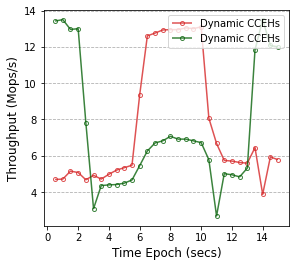

In [12]:
import matplotlib.pyplot as plt
import sys
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.ticker import FuncFormatter
import matplotlib
# plt.rcParams["font.family"] = "arial"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

gloyend = None
# Main
dashes=[(2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0), (2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0)]
markers = ['x', '|', '.', 'D', 'd', '', 'x', '|', '.', 'D', 'd', '']
colors = ['grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434', 'grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434']
# colors = ['#2077B4', '#D62728', '#0A640C', '#343434']

label = ['Dynamic-CCEH0', 'Dynamic-CCEH1', 'Dynamic CCEHs', 'Fixed-CCEH0', 'Fixed-CCEH1', 'Fixed CCEHs']

# d0 d1 represents dynamic CCEH data
# f0 f1 represents fixed CCEH data

fig, ax = plt.subplots(figsize=(4, 3.6), constrained_layout=True, sharex=True, sharey=True)

ax.plot(time_d0, through_d0, color=colors[3], marker=markers[2], dashes=dashes[2], label = label[2], alpha=0.8, fillstyle='none', markersize=8)
ax.plot(time_d1, through_d1, color=colors[4], marker=markers[2], dashes=dashes[2], label = label[2], alpha=0.8, fillstyle='none', markersize=8)


# if (through_d0.shape[0] > through_d1.shape[0]):
#     thr1 = np.pad(through_d1, (0,through_d0.shape[0] - through_d1.shape[0]), 'constant', constant_values=(0,0))
#     ax.plot(time_d0, thr1+through_d0, color=colors[3], marker=markers[2], dashes=dashes[2], label = label[2], alpha=0.8, fillstyle='none', markersize=8)
# else:
#     thr0 = np.pad(through_d0, (0,through_d1.shape[0] - through_d0.shape[0]), 'constant', constant_values=(0,0))
#     ax.plot(time_d1, thr0+through_d1, color=colors[3], marker=markers[2], dashes=dashes[2], label = label[2], alpha=0.8, fillstyle='none', markersize=8)

# if (through_f0.shape[0] > through_f1.shape[0]):
#     thrb = np.pad(through_f1, (0,through_f0.shape[0] - through_f1.shape[0]), 'constant', constant_values=(0,0))
#     ax.plot(time_f0, thrb+through_f0, color=colors[5], marker=markers[5], dashes=dashes[5], label = label[5], alpha=0.8, fillstyle='none', markersize=8)
# else:
#     thra = np.pad(through_f0, (0,through_f1.shape[0] - through_f0.shape[0]), 'constant', constant_values=(0,0))
#     ax.plot(time_f1, thra+through_f1, color=colors[5], marker=markers[5], dashes=dashes[5], label = label[5], alpha=0.8, fillstyle='none', markersize=8)

ax.legend(loc="upper right")
ax.grid(which='major', linestyle='--', zorder=0)
ax.grid(which='minor', linestyle='--', zorder=0, linewidth=0.3)
ax.xaxis.grid(False, which='both')

# ax[0,1].set_title('Time Epoch(1 secs) Throughput \n CCEH0 70% Write CCEH1 100% Write', fontsize = 14)
ax.set_xlabel('Time Epoch (secs)', fontsize=12)
ax.set_ylabel('Throughput (Mops/s)', fontsize=12)


# fig.suptitle(f'CCEH0 0% Write CCEH1 100% Write (Buffer-70K)', fontsize = 14)
# fig.supxlabel('Time Epoch (secs)', fontsize=18)
# fig.supylabel('Throughput (Mops/s)', fontsize=18)

# fig.savefig("results_multi/cmp_g5_onlywritesfactor.pdf", bbox_inches='tight', pad_inches=0)

30


Text(0, 0.5, '# of Buffers (x$10^3$)')

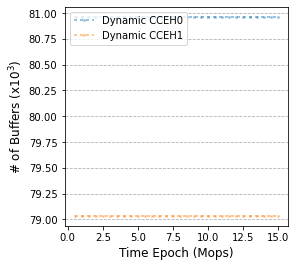

In [13]:

cceh0 = dynamic_buffers['CCEH0_buffers'].values
cceh1 = dynamic_buffers['CCEH1_buffers'].values
print(len(cceh0))
index = [i for i in np.arange(0.5, (len(cceh0) + 1)*0.5, 0.5)]

import matplotlib.pyplot as plt
import sys
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.ticker import FuncFormatter
import matplotlib
# plt.rcParams["font.family"] = "arial"
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

gloyend = None
# Main
dashes=[(2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0), (2,2), (4,1), (2,0), (2,0), (3, 3), (2, 0)]
markers = ['x', '|', '.', 'D', 'd', '', 'x', '|', '.', 'D', 'd', '']
colors = ['grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434', 'grey', '#FF7F0E', '#2077B4', '#D62728', '#0A640C', '#343434']
# colors = ['#2077B4', '#D62728', '#0A640C', '#343434']

label = ['Dynamic CCEH0', 'Dynamic CCEH1']

fig, ax = plt.subplots(figsize=(4, 3.6), constrained_layout=True,)

ax.plot(index, cceh0/1000, color=colors[2], marker=markers[0], dashes=dashes[0], label = label[0], alpha=0.6, fillstyle='none', markersize=2)
ax.plot(index, cceh1/1000, color=colors[7], marker=markers[0], dashes=dashes[0], label = label[1], alpha=0.6, fillstyle='none', markersize=2)

# ax.legend(loc="lower right")
ax.legend(loc="upper left")

ax.grid(which='major', linestyle='--', zorder=0)
ax.grid(which='minor', linestyle='--', zorder=0, linewidth=0.3)
ax.xaxis.grid(False, which='both')

# ax.set_title('Time Epoch(1 secs) Throughput \n CCEH0 0% Write', fontsize = 14)
ax.set_xlabel('Time Epoch (Mops)', fontsize=12)
ax.set_ylabel('# of Buffers (x%s)' % r'$10^3$', fontsize=12)

# if (saveimg):
# fig.savefig("./results_bufferdist/bufferdist_g5_th16.pdf", bbox_inches='tight', pad_inches=0)